In [1]:
import torch
from pettingzoo.mpe import simple_reference_v3,simple_v3
import numpy as np
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
%matplotlib inline

/home/piwalker/code/machine_learning/simple_crypto/venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
max_frames = 5000000
batch_size = 5
learning_rate = 7e-4
gamma = 0.99
entropy_coef = 0.01
critic_coef = 0.5
no_of_workers = 16

In [3]:
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [4]:
class Model(torch.nn.Module):
    def __init__(self, observation_space, action_space):
        super(Model, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Linear(observation_space, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.ReLU()
        )

        self.critic = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1)
        )

        self.actor = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, action_space),
            torch.nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        x = self.features(x)
        value = self.critic(x)
        actions = self.actor(x)
        return value, actions

    def get_critic(self, x):
        x = self.features(x)
        return self.critic(x)
    
    def evaluate_action(self, state, action):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)
        log_probs = dist.log_prob(action).view(-1, 1)
        entropy = dist.entropy().mean()

        return value, log_probs, entropy
    
    def act(self, state):
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        chosen_action = dist.sample()
        return chosen_action.item()

In [5]:
class Memory(object):
    def __init__(self):
        self.states, self.actions, self.true_values = [], [], []
    
    def push(self, state, action, true_value):
        self.states.append(state)
        self.actions.append(action)
        self.true_values.append(true_value)
    
    def pop_all(self):
        states = torch.stack(self.states)
        actions = LongTensor(self.actions)
        true_values = FloatTensor(self.true_values).unsqueeze(1)

        self.states, self.actions, self.true_values = [], [], []
        return states, actions, true_values

In [6]:
class Worker(object):
    def __init__(self):
        self.env = simple_v3.parallel_env()
        self.episode_reward = 0
        self.state = FloatTensor(self.env.reset()[0]["agent_0"])

    def get_batch(self):
        states, actions, rewards, dones = [], [], [], []
        for _ in range(batch_size):
            action = model.act(self.state.unsqueeze(0))
            actiondict = {}
            actiondict["agent_0"] = action
            next_state, reward, terminations, truncations, _ = self.env.step(actiondict)
            self.episode_reward += reward["agent_0"]
            states.append(self.state)
            actions.append(action)
            rewards.append(reward["agent_0"])
            done = False if "agent_0" in terminations else True
            dones.append(done)

            if done:
                self.state = FloatTensor(self.env.reset()[0]["agent_0"])
                data['episode_rewards'].append(self.episode_reward)
                self.episode_reward = 0
            else:
                self.state = FloatTensor(next_state["agent_0"])
        values = compute_true_values(states, rewards, dones).unsqueeze(1)
        return states, actions, values

In [7]:
def compute_true_values(states, rewards, dones):
    true_values = []
    rewards = FloatTensor(rewards)
    dones = FloatTensor(dones)
    states = torch.stack(states)

    if dones[-1] == True:
        next_value = rewards[-1]
    else:
        next_value = model.get_critic(states[-1].unsqueeze(0))

    true_values.append(next_value)
    for i in reversed(range(0, len(rewards) -1)):
        if not dones[i]:
            next_value = rewards[i] + next_value * gamma
        else:
            next_value = rewards[i]
        true_values.append(next_value)
    true_values.reverse()
    return FloatTensor(true_values)

def reflect(memory):
    states, actions, true_values = memory.pop_all()
    values, log_probs, entropy = model.evaluate_action(states, actions)
    advantages = true_values - values
    critic_loss = advantages.pow(2).mean()
    actor_loss = -(log_probs * advantages.detach()).mean()
    total_loss = (critic_coef * critic_loss) + actor_loss - (entropy_coef * entropy)
    optimizer.zero_grad()
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()
    return values.mean().item()

def plot(data, frame_idx):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    if data['episode_rewards']:
        ax = plt.subplot(121)
        ax = plt.gca()
        average_score = np.mean(data['episode_rewards'][-100:])
        plt.title(f"Frame: {frame_idx} - Average Store: {average_score}")
        plt.grid()
        plt.plot(data['episode_rewards'])
    if data['values']:
        ax = plt.subplot(122)
        average_value = np.mean(data['values'][-1000:])
        plt.title(f"Frame: {frame_idx} - Average Values: {average_value}")
        plt.plot(data['values'])
    plt.show()

In [8]:
env = simple_v3.parallel_env()
model = Model(env.observation_space("agent_0").shape[0], env.action_space("agent_0").n)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-5)
memory = Memory()
workers = []
for _ in range(no_of_workers):
    workers.append(Worker())
frame_idx = 0
data = {
    'episode_rewards': [],
    'values': []
}

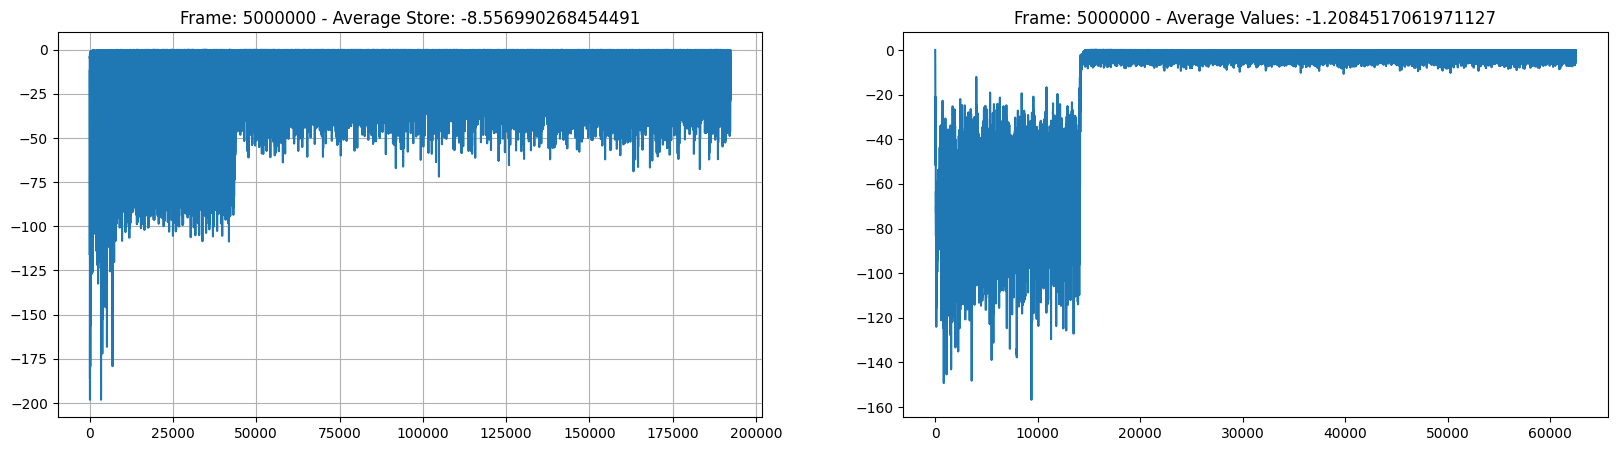

In [9]:
%debug
state = FloatTensor(env.reset()[0]["agent_0"])
episode_reward = 0
while frame_idx < max_frames:
    for worker in workers:
        states, actions, true_values = worker.get_batch()
        for i, _ in enumerate(states):
            memory.push(states[i], actions[i], true_values[i])
        frame_idx += batch_size
    value = reflect(memory)
    data['values'].append(value)
    if frame_idx % 1000 == 0:
        plot(data, frame_idx)

In [10]:
torch.save(model, "MyModel.pt")

In [12]:
env = simple_v3.parallel_env(render_mode="human")
while True:
    state = FloatTensor(env.reset()[0]["agent_0"])
    while env.agents():
        action = model.act(state.unsqueeze(0))
        actiondict = {}
        actiondict["agent_0"] = action
        next_state, reward, terminations, truncations, _ = env.step(actiondict)
        done = False if "agent_0" in terminations else True

        if done:
            state = FloatTensor(env.reset()[0]["agent_0"])
        else:
            state = FloatTensor(next_state["agent_0"])

NameError: name 'self' is not defined